In [1]:
# Add at the top of the notebook
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data-valuation/
!pip install -qr requirements.txt

Mounted at /content/drive
/content/drive/MyDrive/data-valuation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

# MNIST notebook with CLIP embeddings

---

This notebook compares three methods of measuring "diversity" in data
1. [Eigenvalue difference](https://arxiv.org/abs/2208.12354)
2. [Volume](https://github.com/ZhaoxuanWu/VolumeBased-DataValuation)
3. [Vendi Score](https://github.com/vertaix/Vendi-Score)


## Setup

### Module imports

In [2]:
import collections
import math
import os
from importlib import reload
from pathlib import Path

import clip
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import valuation
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from torchvision.datasets import CIFAR10, EMNIST, MNIST, SVHN, FashionMNIST
from torchvision.models import (
    ResNet18_Weights,
    ResNet34_Weights,
    ResNet50_Weights,
    resnet18,
    resnet34,
    resnet50,
)
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.style.use("bmh")
from matplotlib import rcParams

rcParams["font.family"] = "serif"

# local imports
import utils
from valuation import get_value, get_volume

from data import simple_DS, subset

### Make buyer and seller datasets

In [3]:
# path to data directory
root = Path("../data/")

# dowload data if dataset does not exist in data directory
download = True

mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion_seller = FashionMNIST(root=root, train=False, download=download)
cifar_seller = CIFAR10(root=root, train=False, download=download)
emnist_seller = EMNIST(root=root, split="byclass", train=False, download=download)

Files already downloaded and verified


### load pretrained model to embed data

In [4]:
# Path to precompute embeddings
saved_embedding_path = Path("../data/data-markets-data")

# Use cached embeddings
use_precomputed_embeddings = True

# Number of images to use for each seller
num_samples = 10000

# Use CLIP model to compute embeddings
use_clip_model = True


if use_precomputed_embeddings:
    features_dict = dict(
        mnist_buyer=torch.load(saved_embedding_path / "clip_embedding_mnist_buyer.pt")[
            "images"
        ],
        mnist_seller=torch.load(
            saved_embedding_path / "clip_embedding_mnist_seller.pt"
        )["images"],
        fashion_seller=torch.load(
            saved_embedding_path / "clip_embedding_fashion_seller.pt"
        )["images"],
        cifar_seller=torch.load(
            saved_embedding_path / "clip_embedding_cifar_seller.pt"
        )["images"],
        emnist_seller=torch.load(
            saved_embedding_path / "clip_embedding_emnist_seller.pt"
        )["images"][:num_samples],
    )

else:
    assert torch.cuda.is_available()
    if use_clip_model:
        model, preprocess = clip.load("ViT-B/16", device="cuda")
    else:
        model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
        # model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
        # model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()

    model.eval()

    make_loader = lambda x, batch_size=16: torch.utils.data.DataLoader(
        simple_DS(x, transforms=Compose([ToPILImage(), preprocess])),
        batch_size=batch_size,
    )
    data_dict = dict(
        mnist_buyer=mnist_buyer.data,
        mnist_seller=mnist_seller.data,
        fashion_seller=fashion_seller.data,
        cifar_seller=cifar_seller.data,
        emnist_seller=emnist_seller.data.moveaxis(1, -1),
    )
    features_dict = {
        k: torch.cat(
            [
                model.encode_image(x.cuda()).detach().cpu()
                for x in tqdm(
                    make_loader(v[: None if k == "mnist_seller" else num_samples])
                )
            ]
        )
        for k, v in data_dict.items()
    }

### Create seller datasets

In [60]:
cifar_seller.targets

[3,
 8,
 8,
 0,
 6,
 6,
 1,
 6,
 3,
 1,
 0,
 9,
 5,
 7,
 9,
 8,
 5,
 7,
 8,
 6,
 7,
 0,
 4,
 9,
 5,
 2,
 4,
 0,
 9,
 6,
 6,
 5,
 4,
 5,
 9,
 2,
 4,
 1,
 9,
 5,
 4,
 6,
 5,
 6,
 0,
 9,
 3,
 9,
 7,
 6,
 9,
 8,
 0,
 3,
 8,
 8,
 7,
 7,
 4,
 6,
 7,
 3,
 6,
 3,
 6,
 2,
 1,
 2,
 3,
 7,
 2,
 6,
 8,
 8,
 0,
 2,
 9,
 3,
 3,
 8,
 8,
 1,
 1,
 7,
 2,
 5,
 2,
 7,
 8,
 9,
 0,
 3,
 8,
 6,
 4,
 6,
 6,
 0,
 0,
 7,
 4,
 5,
 6,
 3,
 1,
 1,
 3,
 6,
 8,
 7,
 4,
 0,
 6,
 2,
 1,
 3,
 0,
 4,
 2,
 7,
 8,
 3,
 1,
 2,
 8,
 0,
 8,
 3,
 5,
 2,
 4,
 1,
 8,
 9,
 1,
 2,
 9,
 7,
 2,
 9,
 6,
 5,
 6,
 3,
 8,
 7,
 6,
 2,
 5,
 2,
 8,
 9,
 6,
 0,
 0,
 5,
 2,
 9,
 5,
 4,
 2,
 1,
 6,
 6,
 8,
 4,
 8,
 4,
 5,
 0,
 9,
 9,
 9,
 8,
 9,
 9,
 3,
 7,
 5,
 0,
 0,
 5,
 2,
 2,
 3,
 8,
 6,
 3,
 4,
 0,
 5,
 8,
 0,
 1,
 7,
 2,
 8,
 8,
 7,
 8,
 5,
 1,
 8,
 7,
 1,
 3,
 0,
 5,
 7,
 9,
 7,
 4,
 5,
 9,
 8,
 0,
 7,
 9,
 8,
 2,
 7,
 6,
 9,
 4,
 3,
 9,
 6,
 4,
 7,
 6,
 5,
 1,
 5,
 8,
 8,
 0,
 4,
 0,
 5,
 5,
 1,
 1,
 8,
 9,
 0,
 3,
 1,
 9,
 2,
 2,


In [5]:
# number of samples for buyer
num_buyer = 100

# number of samples for each seller
num_seller = 5000

# Buyer has samples from first 5 MNIST digits
buyer_data = features_dict["mnist_buyer"][
    subset(mnist_buyer, ("0 - zero", "1 - one", "2 - two", "3 - three", "4 - four"))
][:num_buyer]

# Sellers with different amounts of class overlap with buyer
seller_1_data = features_dict["mnist_seller"][
    subset(mnist_seller, ("0 - zero", "1 - one", "2 - two", "3 - three", "4 - four"))
][:num_seller]
seller_2_data = features_dict["mnist_seller"][
    subset(mnist_seller, ("1 - one", "2 - two", "3 - three", "4 - four", "5 - five"))
][:num_seller]
seller_3_data = features_dict["mnist_seller"][
    subset(mnist_seller, ("2 - two", "3 - three", "4 - four", "5 - five", "6 - six"))
][:num_seller]
seller_4_data = features_dict["mnist_seller"][
    subset(mnist_seller, ("3 - three", "4 - four", "5 - five", "6 - six", "7 - seven"))
][:num_seller]
seller_5_data = features_dict["mnist_seller"][
    subset(mnist_seller, ("4 - four", "5 - five", "6 - six", "7 - seven", "8 - eight"))
][:num_seller]
seller_6_data = features_dict["mnist_seller"][
    subset(mnist_seller, ("5 - five", "6 - six", "7 - seven", "8 - eight", "9 - nine"))
][:num_seller]

# Sellers with increasing number of classes
seller_7_data = features_dict["mnist_seller"][subset(mnist_seller, ("0 - zero",))][
    :num_seller
]
seller_8_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
        ),
    )
][:num_seller]
seller_9_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
        ),
    )
][:num_seller]
seller_10_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
        ),
    )
][:num_seller]
seller_11_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
            "4 - four",
        ),
    )
][:num_seller]
seller_12_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
            "4 - four",
            "5 - five",
        ),
    )
][:num_seller]
seller_13_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
            "4 - four",
            "5 - five",
            "6 - six",
        ),
    )
][:num_seller]

seller_14_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
            "4 - four",
            "5 - five",
            "6 - six",
            "7 - seven",
        ),
    )
][:num_seller]
seller_15_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
            "4 - four",
            "5 - five",
            "6 - six",
            "7 - seven",
            "8 - eight",
        ),
    )
][:num_seller]


seller_16_data = features_dict["mnist_seller"][
    subset(
        mnist_seller,
        (
            "0 - zero",
            "1 - one",
            "2 - two",
            "3 - three",
            "4 - four",
            "5 - five",
            "6 - six",
            "7 - seven",
            "8 - eight",
            "9 - nine",
        ),
    )
][:num_seller]

emnist_data = features_dict["emnist_seller"][
    subset(
        emnist_seller,
        (
            "A",
            "B",
            "C",
            "D",
            "E",
            "F",
            "G",
            "H",
            "I",
            "J",
            "K",
            "L",
            "M",
            "N",
            "O",
            "P",
            "Q",
            "R",
            "S",
            "T",
            "U",
            "V",
            "W",
            "X",
            "Y",
            "Z",
        ),
    )[:num_samples]
][:num_seller]
fashion_data = features_dict["fashion_seller"][:num_seller]
# svhn_data = features_dict['svhn'][:num_seller]
cifar_data = features_dict["cifar_seller"][:num_seller]

In [6]:
# copy data to measure robustness to duplication

n = seller_1_data.shape[0]
dup_1_data = seller_1_data[: int(n // 2)].repeat(2, 1)  # 50% original
dup_2_data = seller_1_data[: int(n // 4)].repeat(4, 1)  # 25% original
dup_3_data = seller_1_data[: int(n // 10)].repeat(10, 1)  # 10% original
dup_4_data = seller_1_data[: int(n // 20)].repeat(20, 1)  # 5% original
dup_5_data = seller_1_data[: int(n // 50)].repeat(50, 1)  # 2% original

In [7]:
# mixture of MNIST and FashionMNIST datasets

mix_1_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.9)], fashion_data[: int(num_seller * 0.1)]]
)
mix_2_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.8)], fashion_data[: int(num_seller * 0.2)]]
)
mix_3_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.7)], fashion_data[: int(num_seller * 0.3)]]
)
mix_4_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.6)], fashion_data[: int(num_seller * 0.4)]]
)
mix_5_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.5)], fashion_data[: int(num_seller * 0.5)]]
)
mix_6_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.4)], fashion_data[: int(num_seller * 0.6)]]
)
mix_7_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.3)], fashion_data[: int(num_seller * 0.7)]]
)
mix_8_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.2)], fashion_data[: int(num_seller * 0.8)]]
)
mix_9_data = torch.cat(
    [seller_1_data[: int(num_seller * 0.1)], fashion_data[: int(num_seller * 0.9)]]
)

## Data valuation with relevance and diversity measurements


**Market setting**

Assume we have a buyer with some reference data $X^b \in \mathbb{R}^{n_b \times d}$, and we want to value a seller's data $X^s \in \mathbb{R}^{n_s \times d}$ in relation to the buyer's data.
$d$ is the dimension of the embedding, 512 in the case of the CLIP model.

We would like to value the seller's data using two notions of measurement.
1. **Relevance** -- the seller's data should be sufficiently relevant for the buyer i.e. the seller's data should be similar to the buyer's data
2. **Diversity** -- the seller's data should be highly diverse i.e. should contain variation and uniqueness while still being relevant for the buyer  


**Algorithm**

1. First, we project a seller's data into a basis determined by the buyer's data (e.g. eigendecomposition of the covariance matrix / PCA)
    * Decompose the buyer's covariance matrix $(X^b)^T X^b$ to get the eigenvalues $\lambda^b$
    * project the seller's covariance matrix onto $(X^s)^T X^s$ the buyer's principal components
    * Decompose the seller's projected covariance matrix to get the eigenvalues $\hat{\lambda}^s$
2. Then, we compute the diversity and relevance for each seller's data
3. We plot the diversity and relevance measurements to make a relative comparison between sellers

For relevance, we can compute the relevance between buyer and seller using
1. Euclidean distance between mean vectors $\frac{1}{d} \sum \vert\vert \frac{1}{n_b} \sum_i X_i^b -  \frac{1}{n_s} \sum_i X_i^s \vert\vert$
2. Cosine similarity between mean vectors
3. Overlap between eigenvalues $\prod_{i\in C}\min\left(\|\lambda^b_i\|, \|\hat{\lambda}^s_i\|\right)$, where $C$ is the number of components

We compute the diversity in several ways:
1. the difference between eigenvalues $\prod_{i\in \text{C}}\big|\|\lambda^\text{buyer}_i\| - \|\hat{\lambda}^\text{seller}_i\|\big|$
2. the volume of the covariance matrix $\sqrt{\lvert\det((X^s)^T X^s)\rvert}$
3. Vendi Score $\mathrm{VS}(K) = \exp(-\mathrm{tr}(K/n \log K/n)) = \exp(-\sum_{i=1}^n \lambda_i \log \lambda_i)$, where $K$ is a similarity matrix e.g. covariance


### PCA projection

First, we show how to project the seller's data onto the buyer's principal components

In [8]:
# number of PCA components to use
n_components = 10


X_b = buyer_data
# X_b -= X_b.mean(0)

X_s = seller_1_data
# X_s -= X_s.mean(0)


buyer_cov = np.cov(X_b, rowvar=False)

# eigendecomposition of buyer's covariance matrix
buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)

# sort by decreasing eigenvalues
sorted_indices = np.argsort(buyer_eig_val)[::-1]
buyer_values = buyer_eig_val[sorted_indices].real
buyer_components = buyer_eig_vec[:, sorted_indices].real

print(f"first {n_components} components using numpy:", buyer_values[:n_components])

# project seller covariance onto buyer's components
np.linalg.norm(np.cov(X_s, rowvar=False) @ buyer_components[:, :n_components], axis=0)

first 10 components using numpy: [1.20405084 0.92792314 0.51527012 0.48712759 0.26029126 0.23222936
 0.17949771 0.15507689 0.122504   0.10921044]


array([0.90962396, 0.75182777, 0.37658867, 0.39643927, 0.26087934,
       0.19824651, 0.13057721, 0.14068104, 0.09203558, 0.07330611])

**We can also use sklearn's implmentation of PCA to get the same results**

In [9]:
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=False)
pca.fit(X_b)

buyer_values = pca.explained_variance_
buyer_components = pca.components_

# PCA stores mean of previously fitted buyer's data; clear it since we already zero mean the seller data
pca.mean_ = None

print(f"first {n_components} components using sklearn:", buyer_values)
np.linalg.norm(pca.transform(np.cov(X_s, rowvar=False)), axis=0)
# pca.transform(X_b)

first 10 components using sklearn: [1.20405084 0.92792314 0.51527011 0.48712759 0.26029121 0.23222906
 0.17949752 0.1550756  0.12248871 0.10900746]


array([0.90962397, 0.7518277 , 0.37658874, 0.39643929, 0.26087855,
       0.1982379 , 0.13058508, 0.1407127 , 0.09196155, 0.07326614])

### Compute volume-based diversity measure on projected data

In [52]:
reload(valuation)

<module 'valuation' from '/content/drive/MyDrive/data-valuation/valuation.py'>

In [53]:
kwargs = dict(
    threshold=0.1,
    n_components=10,
    omega=0.1,
    norm_volume=True,
    include_vendi_score=True,
)

In [61]:
buyer_data = cifar_data[:100]

In [62]:
buyer_values = valuation.get_value(buyer_data, buyer_data, **kwargs)
seller_1_values = valuation.get_value(buyer_data, seller_1_data, **kwargs)
seller_2_values = valuation.get_value(buyer_data, seller_2_data, **kwargs)
seller_3_values = valuation.get_value(buyer_data, seller_3_data, **kwargs)
seller_4_values = valuation.get_value(buyer_data, seller_4_data, **kwargs)
seller_5_values = valuation.get_value(buyer_data, seller_5_data, **kwargs)
seller_6_values = valuation.get_value(buyer_data, seller_6_data, **kwargs)
seller_7_values = valuation.get_value(buyer_data, seller_7_data, **kwargs)
seller_8_values = valuation.get_value(buyer_data, seller_8_data, **kwargs)
seller_9_values = valuation.get_value(buyer_data, seller_9_data, **kwargs)
seller_10_values = valuation.get_value(buyer_data, seller_10_data, **kwargs)
seller_11_values = valuation.get_value(buyer_data, seller_11_data, **kwargs)
seller_12_values = valuation.get_value(buyer_data, seller_12_data, **kwargs)
seller_13_values = valuation.get_value(buyer_data, seller_13_data, **kwargs)
seller_14_values = valuation.get_value(buyer_data, seller_14_data, **kwargs)
seller_15_values = valuation.get_value(buyer_data, seller_15_data, **kwargs)
seller_16_values = valuation.get_value(buyer_data, seller_16_data, **kwargs)

dup_1_values = valuation.get_value(buyer_data, dup_1_data, **kwargs)
dup_2_values = valuation.get_value(buyer_data, dup_2_data, **kwargs)
dup_3_values = valuation.get_value(buyer_data, dup_3_data, **kwargs)
dup_4_values = valuation.get_value(buyer_data, dup_4_data, **kwargs)
dup_5_values = valuation.get_value(buyer_data, dup_5_data, **kwargs)

mix_1_values = valuation.get_value(buyer_data, mix_1_data, **kwargs)
mix_2_values = valuation.get_value(buyer_data, mix_2_data, **kwargs)
mix_3_values = valuation.get_value(buyer_data, mix_3_data, **kwargs)
mix_4_values = valuation.get_value(buyer_data, mix_4_data, **kwargs)
mix_5_values = valuation.get_value(buyer_data, mix_5_data, **kwargs)
mix_6_values = valuation.get_value(buyer_data, mix_6_data, **kwargs)
mix_7_values = valuation.get_value(buyer_data, mix_7_data, **kwargs)
mix_8_values = valuation.get_value(buyer_data, mix_8_data, **kwargs)
mix_9_values = valuation.get_value(buyer_data, mix_9_data, **kwargs)

emnist_values = valuation.get_value(buyer_data, emnist_data, **kwargs)
fashion_values = valuation.get_value(buyer_data, fashion_data, **kwargs)
# cifar_values = valuation.get_value(buyer_data, cifar_data, **kwargs)
cifar_values = valuation.get_value(buyer_data, cifar_data[100:], **kwargs)

In [63]:
# where to save plots
figures = Path("figures")
figures.mkdir(exist_ok=True, parents=True)

### Compare diversity measures when sellers have different amounts of overlapping classes

In [64]:
from vendi_score import vendi

vendi.score_dual(seller_2_data, normalize=True)

seller_2_values["vendi"]

1.335165

<ipython-input-65-b90b0c2d0596>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
<ipython-input-65-b90b0c2d0596>:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f"{y:.1f}" for y in ax[0].get_yticks()], fontsize=fontsize - 8)
<ipython-input-65-b90b0c2d0596>:202: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
<ipython-input-65-b90b0c2d0596>:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
<ipython-input-65-b90b0c2d0596>:294: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels([f"{x:.1f}" for x in ax[2].get_xticks()], fontsize=fontsize - 8)
<ipy

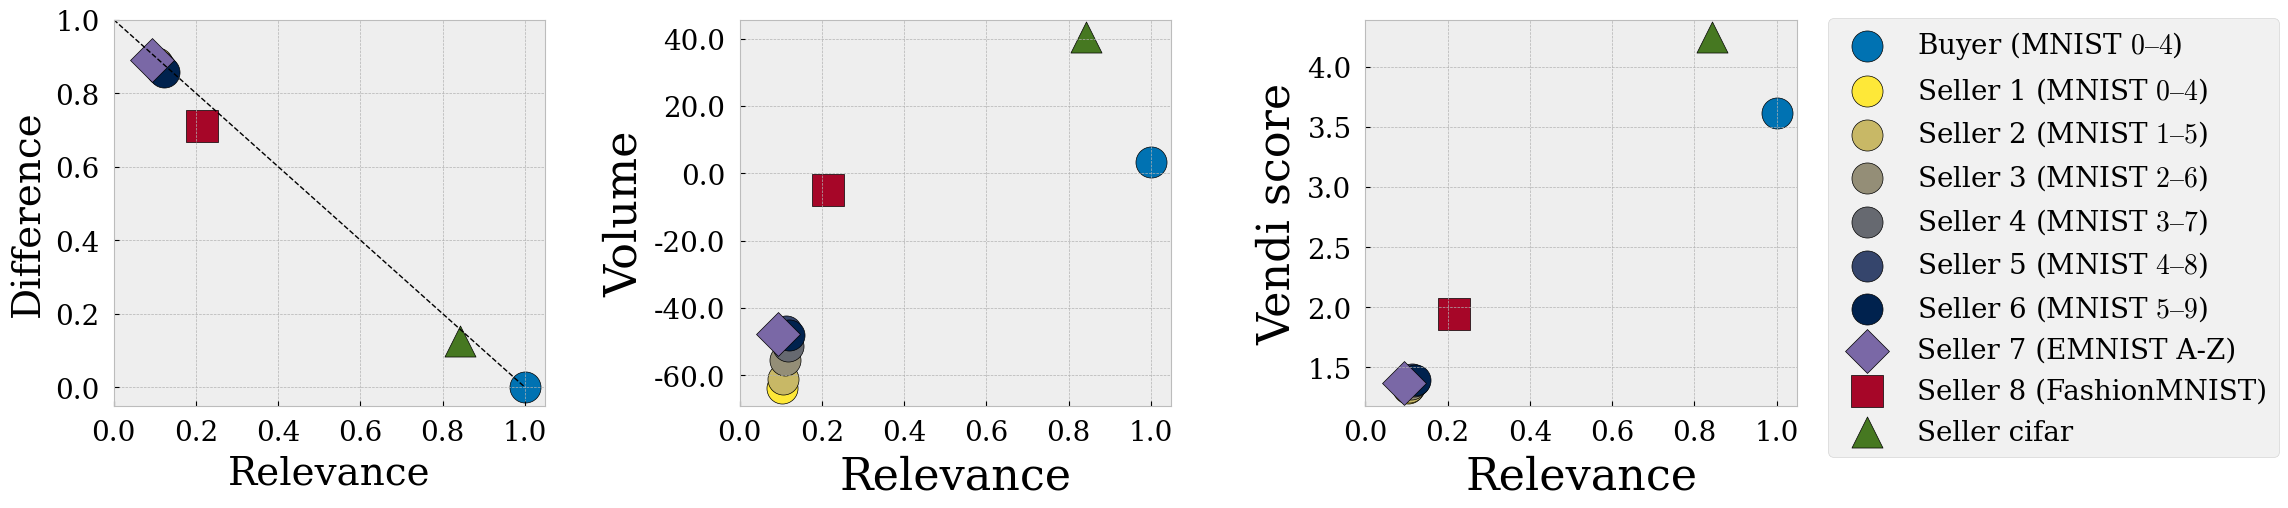

In [65]:
cividis = [
    np.array([matplotlib.colormaps["cividis"].colors[int(k)]])
    for k in np.linspace(255, 0, 6)
]

fontsize = 28
s = 500

fig, ax = plt.subplots(figsize=(19, 6), ncols=3)

ax[0].scatter(
    buyer_values["relevance"],
    buyer_values["diversity"],
    c="#0072B2",
    edgecolor="k",
    s=s,
    label=r"Buyer MNIST $0–4$",
)
ax[0].scatter(
    seller_1_values["relevance"],
    seller_1_values["diversity"],
    c=cividis[0],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $0–4$",
)
ax[0].scatter(
    seller_2_values["relevance"],
    seller_2_values["diversity"],
    c=cividis[1],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $1–5$",
)
ax[0].scatter(
    seller_3_values["relevance"],
    seller_3_values["diversity"],
    c=cividis[2],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $2–6$",
)
ax[0].scatter(
    seller_4_values["relevance"],
    seller_4_values["diversity"],
    c=cividis[3],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $3–7$",
)
ax[0].scatter(
    seller_5_values["relevance"],
    seller_5_values["diversity"],
    c=cividis[4],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $4–8$",
)
ax[0].scatter(
    seller_6_values["relevance"],
    seller_6_values["diversity"],
    c=cividis[5],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $5–9$",
)
ax[0].scatter(
    emnist_values["relevance"],
    emnist_values["diversity"],
    c="C2",
    edgecolor="k",
    s=s,
    marker="D",
    label=r"Seller emnist",
)
ax[0].scatter(
    fashion_values["relevance"],
    fashion_values["diversity"],
    c="C1",
    edgecolor="k",
    s=s,
    marker="s",
    label=r"Seller fashion",
)
ax[0].scatter(
    cifar_values["relevance"],
    cifar_values["diversity"],
    c="C3",
    edgecolor="k",
    s=s,
    marker="^",
    label=r"Seller cifar",
)

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(
    np.arange(0, 1.1, 0.1),
    1 - np.arange(0, 1.1, 0.1),
    marker="",
    markersize=4,
    markeredgewidth=1.5,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[0].set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
ax[0].set_ylabel("Difference", fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
ax[0].set_yticklabels([f"{y:.1f}" for y in ax[0].get_yticks()], fontsize=fontsize - 8)
ax[0].tick_params(axis="both", which="major", pad=10)

ax[1].scatter(
    buyer_values["relevance"],
    buyer_values["volume"],
    c="#0072B2",
    edgecolor="k",
    s=s,
    label=r"Buyer (MNIST $0–4$)",
)
ax[1].scatter(
    seller_1_values["relevance"],
    seller_1_values["volume"],
    c=cividis[0],
    edgecolor="k",
    s=s,
    label=r"Seller 1 (MNIST $0–4$)",
)
ax[1].scatter(
    seller_2_values["relevance"],
    seller_2_values["volume"],
    c=cividis[1],
    edgecolor="k",
    s=s,
    label=r"Seller 2 (MNIST $1–5$)",
)
ax[1].scatter(
    seller_3_values["relevance"],
    seller_3_values["volume"],
    c=cividis[2],
    edgecolor="k",
    s=s,
    label=r"Seller 3 (MNIST $2–6$)",
)
ax[1].scatter(
    seller_4_values["relevance"],
    seller_4_values["volume"],
    c=cividis[3],
    edgecolor="k",
    s=s,
    label=r"Seller 4 (MNIST $3–7$)",
)
ax[1].scatter(
    seller_5_values["relevance"],
    seller_5_values["volume"],
    c=cividis[4],
    edgecolor="k",
    s=s,
    label=r"Seller 5 (MNIST $4–8$)",
)
ax[1].scatter(
    seller_6_values["relevance"],
    seller_6_values["volume"],
    c=cividis[5],
    edgecolor="k",
    s=s,
    label=r"Seller 6 (MNIST $5–9$)",
)
ax[1].scatter(
    emnist_values["relevance"],
    emnist_values["volume"],
    c="C2",
    edgecolor="k",
    s=s,
    marker="D",
    label=r"Seller 7 (EMNIST A-Z)",
)
ax[1].scatter(
    fashion_values["relevance"],
    fashion_values["volume"],
    c="C1",
    edgecolor="k",
    s=s,
    marker="s",
    label=r"Seller 8 (FashionMNIST)",
)
ax[1].scatter(
    cifar_values["relevance"],
    cifar_values["volume"],
    c="C3",
    edgecolor="k",
    s=s,
    marker="^",
    label=r"Seller cifar",
)

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel("Relevance", fontsize=32, labelpad=6)
ax[1].set_ylabel("Volume", fontsize=32, labelpad=6)
ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
# ax[1].set_yscale('log',base=2)
ax[1].tick_params(axis="both", which="major", pad=10)

ax[2].scatter(
    buyer_values["relevance"],
    buyer_values["vendi"],
    c="#0072B2",
    edgecolor="k",
    s=s,
    label=r"Buyer (MNIST $0–4$)",
)
ax[2].scatter(
    seller_1_values["relevance"],
    seller_1_values["vendi"],
    c=cividis[0],
    edgecolor="k",
    s=s,
    label=r"Seller 1 (MNIST $0–4$)",
)
ax[2].scatter(
    seller_2_values["relevance"],
    seller_2_values["vendi"],
    c=cividis[1],
    edgecolor="k",
    s=s,
    label=r"Seller 2 (MNIST $1–5$)",
)
ax[2].scatter(
    seller_3_values["relevance"],
    seller_3_values["vendi"],
    c=cividis[2],
    edgecolor="k",
    s=s,
    label=r"Seller 3 (MNIST $2–6$)",
)
ax[2].scatter(
    seller_4_values["relevance"],
    seller_4_values["vendi"],
    c=cividis[3],
    edgecolor="k",
    s=s,
    label=r"Seller 4 (MNIST $3–7$)",
)
ax[2].scatter(
    seller_5_values["relevance"],
    seller_5_values["vendi"],
    c=cividis[4],
    edgecolor="k",
    s=s,
    label=r"Seller 5 (MNIST $4–8$)",
)
ax[2].scatter(
    seller_6_values["relevance"],
    seller_6_values["vendi"],
    c=cividis[5],
    edgecolor="k",
    s=s,
    label=r"Seller 6 (MNIST $5–9$)",
)
ax[2].scatter(
    emnist_values["relevance"],
    emnist_values["vendi"],
    c="C2",
    edgecolor="k",
    s=s,
    marker="D",
    label=r"Seller 7 (EMNIST A-Z)",
)
ax[2].scatter(
    fashion_values["relevance"],
    fashion_values["vendi"],
    c="C1",
    edgecolor="k",
    s=s,
    marker="s",
    label=r"Seller 8 (FashionMNIST)",
)
ax[2].scatter(
    cifar_values["relevance"],
    cifar_values["vendi"],
    c="C3",
    edgecolor="k",
    s=s,
    marker="^",
    label=r"Seller cifar",
)

ax[2].set_xlim(0, 1.05)
ax[2].set_xlabel("Relevance", fontsize=32, labelpad=6)
ax[2].set_ylabel("Vendi score", fontsize=32, labelpad=6)
ax[2].set_xticklabels([f"{x:.1f}" for x in ax[2].get_xticks()], fontsize=fontsize - 8)
ax[2].set_yticklabels([y for y in ax[2].get_yticks()], fontsize=fontsize - 8)
ax[2].tick_params(axis="both", which="major", pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={"size": fontsize - 8}, bbox_to_anchor=(1.04, 1.04))
# plt.savefig(figures / f'mnist-compare-diversity-clip-overlap-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

<ipython-input-66-ef45dd2ddcda>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[d].set_xticklabels([f"{x:.1f}" for x in ax[d].get_xticks()], fontsize=fontsize - 8)
<ipython-input-66-ef45dd2ddcda>:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[d].set_yticklabels([f"{y:.1f}" for y in ax[d].get_yticks()], fontsize=fontsize - 8)


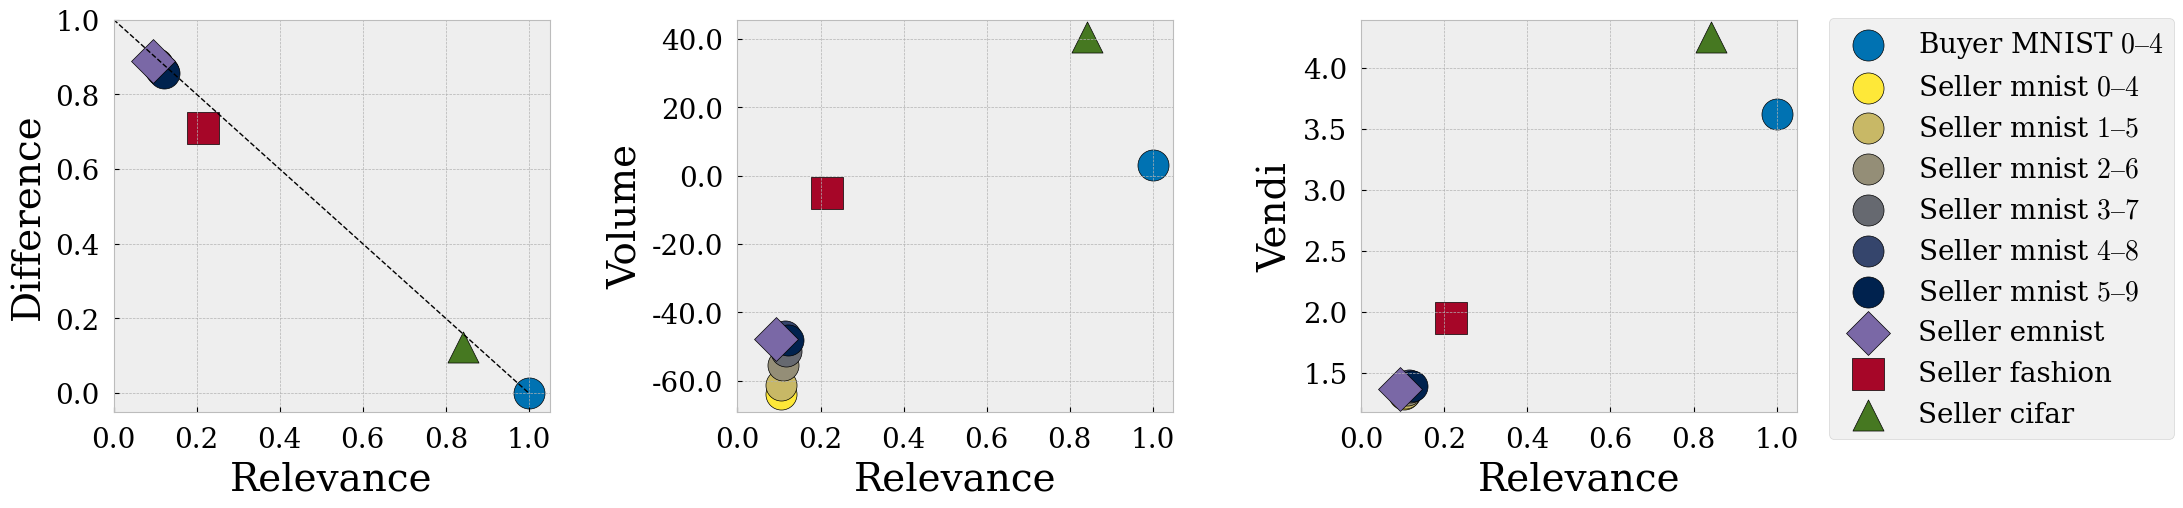

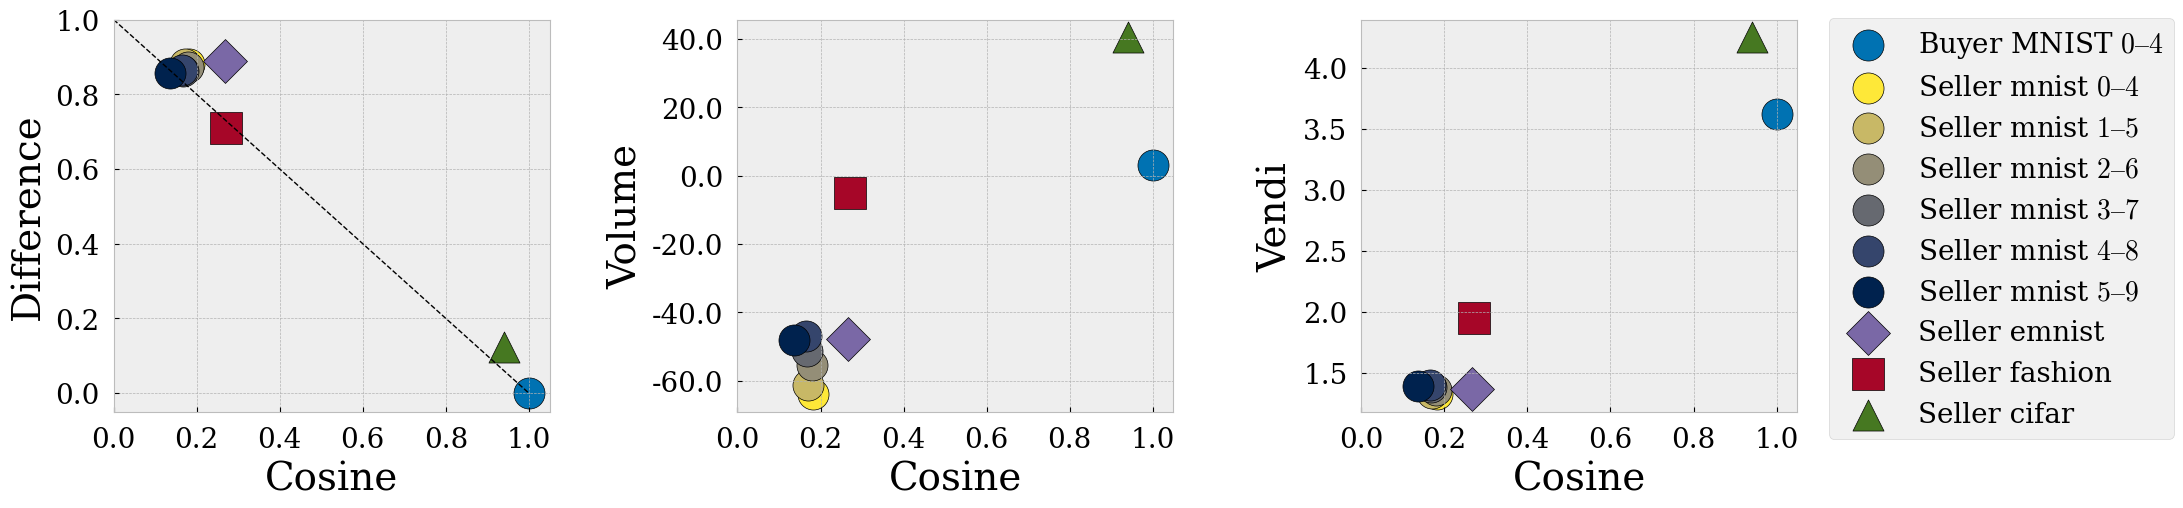

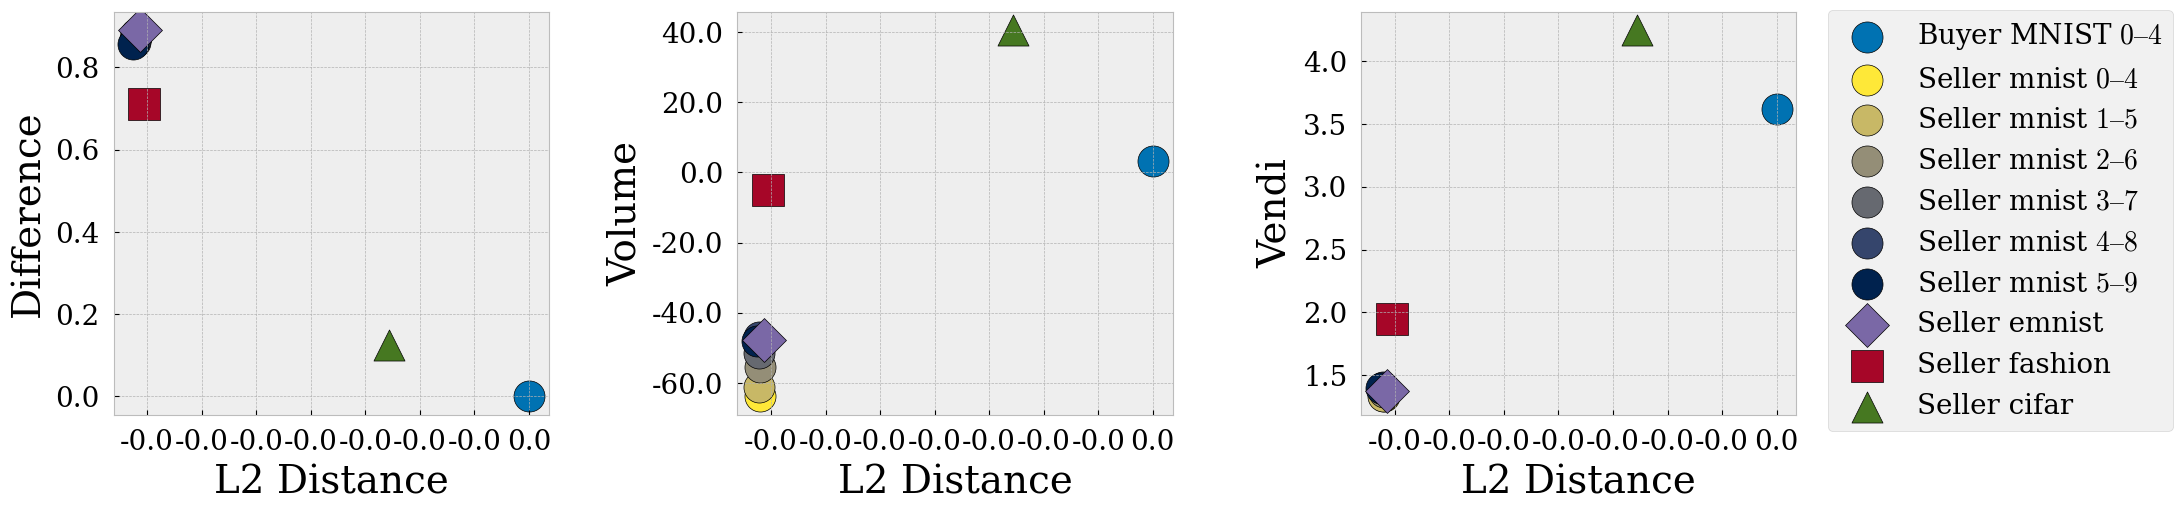

In [66]:
### ALL PLOTS
cividis = [
    np.array([matplotlib.colormaps["cividis"].colors[int(k)]])
    for k in np.linspace(255, 0, 6)
]

diversity_metric = {
    0: ["diversity", "Difference"],
    1: ["volume", "Volume"],
    2: ["vendi", "Vendi"],
}

relevance_metric = {
    0: ["relevance", "Relevance"],
    1: ["cosine", "Cosine"],
    2: ["l2", "L2 Distance"],
}

for r in range(3):
  fontsize = 28
  s = 500

  fig, ax = plt.subplots(figsize=(19, 6), ncols=3)

  for d in range(3):
    diversity_values = diversity_metric[d][0]
    diversity_label = diversity_metric[d][1]
    relevance_values = relevance_metric[r][0]
    relevance_label = relevance_metric[r][1]

    ax[d].scatter(
        buyer_values[relevance_values],
        buyer_values[diversity_values],
        c="#0072B2",
        edgecolor="k",
        s=s,
        label=r"Buyer MNIST $0–4$",
    )
    ax[d].scatter(
        seller_1_values[relevance_values],
        seller_1_values[diversity_values],
        c=cividis[0],
        edgecolor="k",
        s=s,
        label=r"Seller mnist $0–4$",
    )
    ax[d].scatter(
        seller_2_values[relevance_values],
        seller_2_values[diversity_values],
        c=cividis[1],
        edgecolor="k",
        s=s,
        label=r"Seller mnist $1–5$",
    )
    ax[d].scatter(
        seller_3_values[relevance_values],
        seller_3_values[diversity_values],
        c=cividis[2],
        edgecolor="k",
        s=s,
        label=r"Seller mnist $2–6$",
    )
    ax[d].scatter(
        seller_4_values[relevance_values],
        seller_4_values[diversity_values],
        c=cividis[3],
        edgecolor="k",
        s=s,
        label=r"Seller mnist $3–7$",
    )
    ax[d].scatter(
        seller_5_values[relevance_values],
        seller_5_values[diversity_values],
        c=cividis[4],
        edgecolor="k",
        s=s,
        label=r"Seller mnist $4–8$",
    )
    ax[d].scatter(
        seller_6_values[relevance_values],
        seller_6_values[diversity_values],
        c=cividis[5],
        edgecolor="k",
        s=s,
        label=r"Seller mnist $5–9$",
    )
    ax[d].scatter(
        emnist_values[relevance_values],
        emnist_values[diversity_values],
        c="C2",
        edgecolor="k",
        s=s,
        marker="D",
        label=r"Seller emnist",
    )
    ax[d].scatter(
        fashion_values[relevance_values],
        fashion_values[diversity_values],
        c="C1",
        edgecolor="k",
        s=s,
        marker="s",
        label=r"Seller fashion",
    )
    ax[d].scatter(
        cifar_values[relevance_values],
        cifar_values[diversity_values],
        c="C3",
        edgecolor="k",
        s=s,
        marker="^",
        label=r"Seller cifar",
    )

    if r < 2:
      ax[d].set_xlim(0, 1.05)
      if d%3 == 0:
        ax[d].set_ylim(-0.05, 1)
        ax[d].plot(
            np.arange(0, 1.1, 0.1),
            1 - np.arange(0, 1.1, 0.1),
            marker="",
            markersize=4,
            markeredgewidth=1.5,
            color="black",
            linestyle="--",
            linewidth=1,
        )
    ax[d].set_xlabel(relevance_label, fontsize=fontsize, labelpad=6)
    ax[d].set_ylabel(diversity_label, fontsize=fontsize, labelpad=6)
    ax[d].set_xticklabels([f"{x:.1f}" for x in ax[d].get_xticks()], fontsize=fontsize - 8)
    ax[d].set_yticklabels([f"{y:.1f}" for y in ax[d].get_yticks()], fontsize=fontsize - 8)
    ax[d].tick_params(axis="both", which="major", pad=10)

  plt.tight_layout(pad=4)
  plt.legend(prop={"size": fontsize - 8}, bbox_to_anchor=(1.04, 1.04))
  # plt.savefig(figures / f'mnist-compare-diversity-clip-overlap-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
  plt.show()

### Compare diversity measures when sellers have increasing number of unique classes

<ipython-input-67-76d468c7d403>:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
<ipython-input-67-76d468c7d403>:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f"{y:.1f}" for y in ax[0].get_yticks()], fontsize=fontsize - 8)
<ipython-input-67-76d468c7d403>:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
<ipython-input-67-76d468c7d403>:252: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
<ipython-input-67-76d468c7d403>:375: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels([f"{x:.1f}" for x in ax[2].get_xticks()], fontsize=fontsize - 8)
<ipy

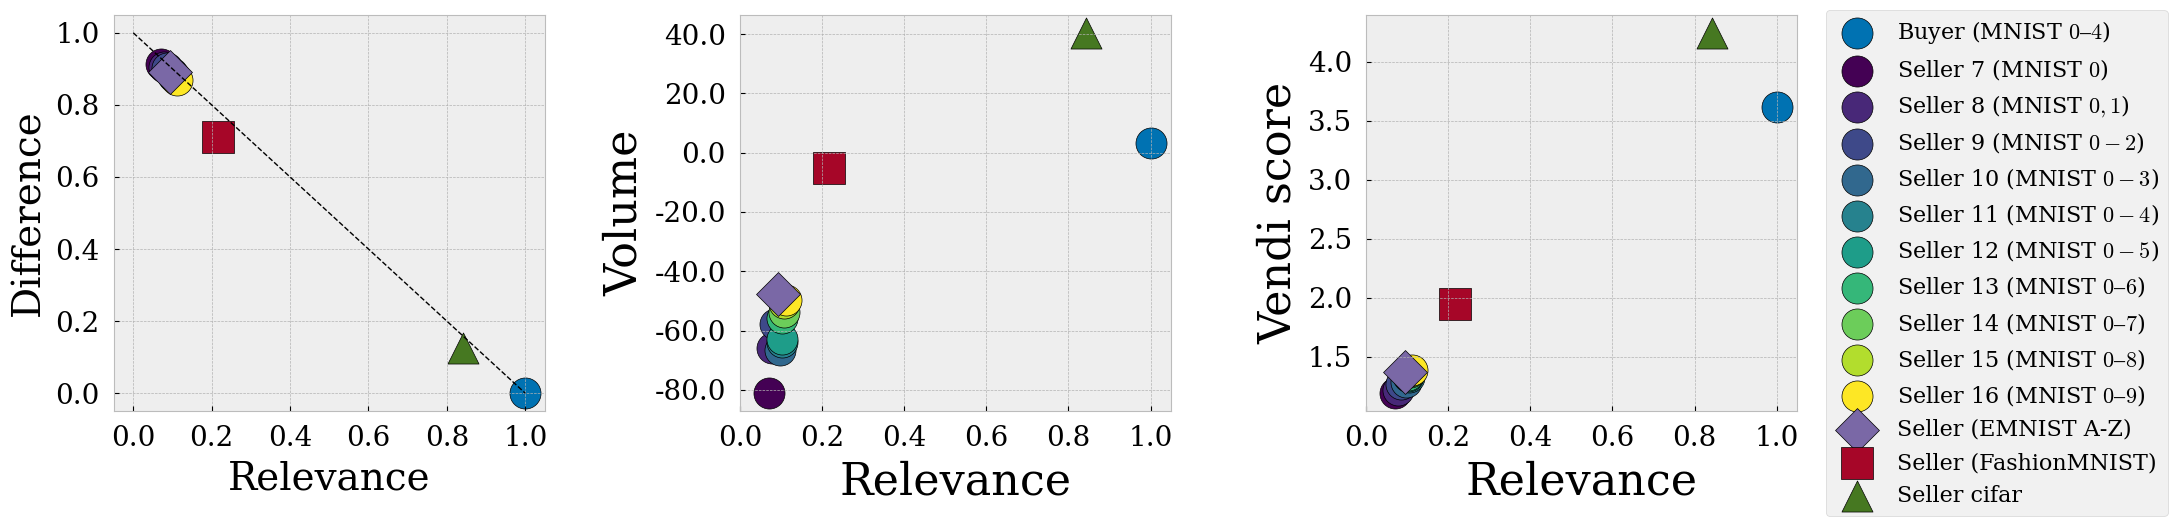

In [67]:
viridis = [
    np.array([matplotlib.colormaps["viridis"].colors[int(k)]])
    for k in np.linspace(0, 255, 10)
]

fontsize = 28
s = 500

fig, ax = plt.subplots(figsize=(19, 6), ncols=3)

ax[0].scatter(
    buyer_values["relevance"],
    buyer_values["diversity"],
    c="#0072B2",
    edgecolor="k",
    s=s,
    label=r"Buyer MNIST $0–4$",
)
ax[0].scatter(
    seller_7_values["relevance"],
    seller_7_values["diversity"],
    c=viridis[0],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_8_values["relevance"],
    seller_8_values["diversity"],
    c=viridis[1],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_9_values["relevance"],
    seller_9_values["diversity"],
    c=viridis[2],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_10_values["relevance"],
    seller_10_values["diversity"],
    c=viridis[3],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_11_values["relevance"],
    seller_11_values["diversity"],
    c=viridis[4],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_12_values["relevance"],
    seller_12_values["diversity"],
    c=viridis[5],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_13_values["relevance"],
    seller_13_values["diversity"],
    c=viridis[6],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_14_values["relevance"],
    seller_14_values["diversity"],
    c=viridis[7],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_15_values["relevance"],
    seller_15_values["diversity"],
    c=viridis[8],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    seller_16_values["relevance"],
    seller_16_values["diversity"],
    c=viridis[9],
    edgecolor="k",
    s=s,
)
ax[0].scatter(
    emnist_values["relevance"],
    emnist_values["diversity"],
    c="C2",
    edgecolor="k",
    s=s,
    marker="D",
)
ax[0].scatter(
    fashion_values["relevance"],
    fashion_values["diversity"],
    c="C1",
    edgecolor="k",
    s=s,
    marker="s",
)
ax[0].scatter(
    cifar_values["relevance"],
    cifar_values["diversity"],
    c="C3",
    edgecolor="k",
    s=s,
    marker="^",
)

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(
    np.arange(0, 1.1, 0.1),
    1 - np.arange(0, 1.1, 0.1),
    marker="",
    markersize=4,
    markeredgewidth=1.5,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[0].set_xlabel("Relevance", fontsize=fontsize, labelpad=6)
ax[0].set_ylabel("Difference", fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
ax[0].set_yticklabels([f"{y:.1f}" for y in ax[0].get_yticks()], fontsize=fontsize - 8)
ax[0].tick_params(axis="both", which="major", pad=10)

ax[1].scatter(
    buyer_values["relevance"],
    buyer_values["volume"],
    c="#0072B2",
    edgecolor="k",
    s=s,
    label=r"Buyer (MNIST $0–4$)",
)
ax[1].scatter(
    seller_7_values["relevance"],
    seller_7_values["volume"],
    c=viridis[0],
    edgecolor="k",
    s=s,
    label=r"Seller 7 (MNIST $0$)",
)
ax[1].scatter(
    seller_8_values["relevance"],
    seller_8_values["volume"],
    c=viridis[1],
    edgecolor="k",
    s=s,
    label=r"Seller 8 (MNIST $0,1$)",
)
ax[1].scatter(
    seller_9_values["relevance"],
    seller_9_values["volume"],
    c=viridis[2],
    edgecolor="k",
    s=s,
    label=r"Seller 9 (MNIST $0-2$)",
)
ax[1].scatter(
    seller_10_values["relevance"],
    seller_10_values["volume"],
    c=viridis[3],
    edgecolor="k",
    s=s,
    label=r"Seller 10 (MNIST $0-3$)",
)
ax[1].scatter(
    seller_11_values["relevance"],
    seller_11_values["volume"],
    c=viridis[4],
    edgecolor="k",
    s=s,
    label=r"Seller 11 (MNIST $0-4$)",
)
ax[1].scatter(
    seller_12_values["relevance"],
    seller_12_values["volume"],
    c=viridis[5],
    edgecolor="k",
    s=s,
    label=r"Seller 12 (MNIST $0-5$)",
)
ax[1].scatter(
    seller_13_values["relevance"],
    seller_13_values["volume"],
    c=viridis[6],
    edgecolor="k",
    s=s,
    label=r"Seller 13 (MNIST $0–6$)",
)
ax[1].scatter(
    seller_14_values["relevance"],
    seller_14_values["volume"],
    c=viridis[7],
    edgecolor="k",
    s=s,
    label=r"Seller 14 (MNIST $0–7$)",
)
ax[1].scatter(
    seller_15_values["relevance"],
    seller_15_values["volume"],
    c=viridis[8],
    edgecolor="k",
    s=s,
    label=r"Seller 15 (MNIST $0–8$)",
)
ax[1].scatter(
    seller_16_values["relevance"],
    seller_16_values["volume"],
    c=viridis[9],
    edgecolor="k",
    s=s,
    label=r"Seller 16 (MNIST $0–9$)",
)
ax[1].scatter(
    emnist_values["relevance"],
    emnist_values["volume"],
    c="C2",
    edgecolor="k",
    s=s,
    marker="D",
    label=r"Seller (EMNIST A-Z)",
)
ax[1].scatter(
    fashion_values["relevance"],
    fashion_values["volume"],
    c="C1",
    edgecolor="k",
    s=s,
    marker="s",
    label=r"Seller (FashionMNIST)",
)
ax[1].scatter(
    cifar_values["relevance"],
    cifar_values["volume"],
    c="C3",
    edgecolor="k",
    s=s,
    marker="^",
    label=r"Seller cifar",
)

ax[1].set_xlim(0.0, 1.05)
ax[1].set_xlabel("Relevance", fontsize=32, labelpad=6)
ax[1].set_ylabel("Volume", fontsize=32, labelpad=6)
ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
ax[1].tick_params(axis="both", which="major", pad=10)


ax[2].scatter(
    buyer_values["relevance"],
    buyer_values["vendi"],
    c="#0072B2",
    edgecolor="k",
    s=s,
    label=r"Buyer (MNIST $0–4$)",
)
ax[2].scatter(
    seller_7_values["relevance"],
    seller_7_values["vendi"],
    c=viridis[0],
    edgecolor="k",
    s=s,
    label=r"Seller 7 (MNIST $0$)",
)
ax[2].scatter(
    seller_8_values["relevance"],
    seller_8_values["vendi"],
    c=viridis[1],
    edgecolor="k",
    s=s,
    label=r"Seller 8 (MNIST $0,1$)",
)
ax[2].scatter(
    seller_9_values["relevance"],
    seller_9_values["vendi"],
    c=viridis[2],
    edgecolor="k",
    s=s,
    label=r"Seller 9 (MNIST $0-2$)",
)
ax[2].scatter(
    seller_10_values["relevance"],
    seller_10_values["vendi"],
    c=viridis[3],
    edgecolor="k",
    s=s,
    label=r"Seller 10 (MNIST $0-3$)",
)
ax[2].scatter(
    seller_11_values["relevance"],
    seller_11_values["vendi"],
    c=viridis[4],
    edgecolor="k",
    s=s,
    label=r"Seller 11 (MNIST $0-4$)",
)
ax[2].scatter(
    seller_12_values["relevance"],
    seller_12_values["vendi"],
    c=viridis[5],
    edgecolor="k",
    s=s,
    label=r"Seller 12 (MNIST $0-5$)",
)
ax[2].scatter(
    seller_13_values["relevance"],
    seller_13_values["vendi"],
    c=viridis[6],
    edgecolor="k",
    s=s,
    label=r"Seller 13 (MNIST $0–6$)",
)
ax[2].scatter(
    seller_14_values["relevance"],
    seller_14_values["vendi"],
    c=viridis[7],
    edgecolor="k",
    s=s,
    label=r"Seller 14 (MNIST $0–7$)",
)
ax[2].scatter(
    seller_15_values["relevance"],
    seller_15_values["vendi"],
    c=viridis[8],
    edgecolor="k",
    s=s,
    label=r"Seller 15 (MNIST $0–8$)",
)
ax[2].scatter(
    seller_16_values["relevance"],
    seller_16_values["vendi"],
    c=viridis[9],
    edgecolor="k",
    s=s,
    label=r"Seller 16 (MNIST $0–9$)",
)
ax[2].scatter(
    emnist_values["relevance"],
    emnist_values["vendi"],
    c="C2",
    edgecolor="k",
    s=s,
    marker="D",
    label=r"Seller (EMNIST A-Z)",
)
ax[2].scatter(
    fashion_values["relevance"],
    fashion_values["vendi"],
    c="C1",
    edgecolor="k",
    s=s,
    marker="s",
    label=r"Seller (FashionMNIST)",
)
ax[2].scatter(
    cifar_values["relevance"],
    cifar_values["vendi"],
    c="C3",
    edgecolor="k",
    s=s,
    marker="^",
    label=r"Seller cifar",
)

ax[2].set_xlim(0.0, 1.05)
ax[2].set_xlabel("Relevance", fontsize=32, labelpad=6)
ax[2].set_ylabel("Vendi score", fontsize=32, labelpad=6)
ax[2].set_xticklabels([f"{x:.1f}" for x in ax[2].get_xticks()], fontsize=fontsize - 8)
ax[2].set_yticklabels([y for y in ax[2].get_yticks()], fontsize=fontsize - 8)
ax[2].tick_params(axis="both", which="major", pad=10)


plt.tight_layout(pad=4)
plt.legend(prop={"size": fontsize - 12}, bbox_to_anchor=(1.04, 1.04))
# plt.savefig(figures / f'mnist-compare-diversity-clip-classes-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing amount of duplicated data

<ipython-input-68-17dc6335e0cb>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
<ipython-input-68-17dc6335e0cb>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize - 8)
<ipython-input-68-17dc6335e0cb>:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
<ipython-input-68-17dc6335e0cb>:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
<ipython-input-68-17dc6335e0cb>:112: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels([f"{x:.1f}" for x in ax[2].get_xticks()], fontsize=fontsize - 8)
<ipython

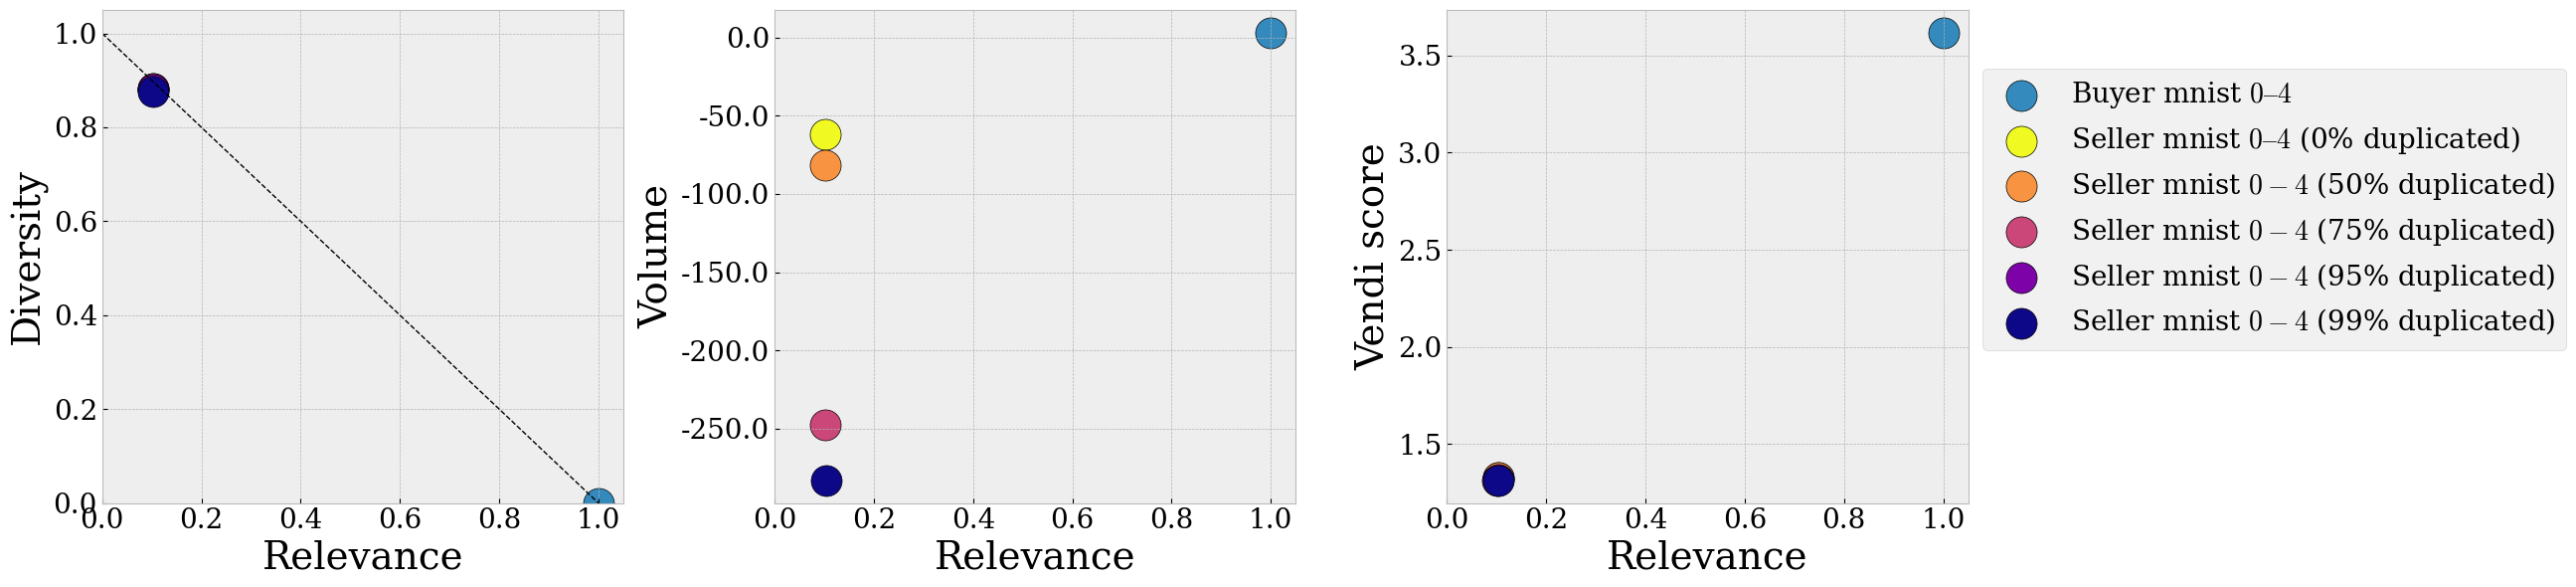

In [68]:
plasma = np.array(
    [matplotlib.colormaps["plasma"].colors[int(k)] for k in np.linspace(255, 0, 5)]
)[:, None]

s = 500
fs = 28
fig, ax = plt.subplots(figsize=(20, 6), ncols=3)

ax[0].scatter(
    buyer_values["relevance"],
    buyer_values["diversity"],
    edgecolor="k",
    s=s,
    label=r"Buyer mnist $0–4$",
)
ax[0].scatter(
    dup_1_values["relevance"],
    dup_1_values["diversity"],
    c=plasma[0],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $0–4$ (0% duplicated)",
)
ax[0].scatter(
    dup_2_values["relevance"],
    dup_2_values["diversity"],
    c=plasma[1],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $0-4$ (50% duplicated)",
)
ax[0].scatter(
    dup_3_values["relevance"],
    dup_3_values["diversity"],
    c=plasma[2],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $0-4$ (75% duplicated)",
)
ax[0].scatter(
    dup_4_values["relevance"],
    dup_4_values["diversity"],
    c=plasma[3],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $0-4$ (95% duplicated)",
)
ax[0].scatter(
    dup_5_values["relevance"],
    dup_5_values["diversity"],
    c=plasma[4],
    edgecolor="k",
    s=s,
    label=r"Seller mnist $0-4$ (99% duplicated)",
)
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize - 8)
ax[0].plot(
    np.arange(0, 1.1, 0.1),
    1 - np.arange(0, 1.1, 0.1),
    marker="",
    markersize=4,
    markeredgewidth=1.5,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[0].set_xlabel("Relevance", fontsize=fs)
ax[0].set_ylabel("Diversity", fontsize=fs)

ax[1].scatter(buyer_values["relevance"], buyer_values["volume"], edgecolor="k", s=s)
ax[1].scatter(
    dup_1_values["relevance"], dup_1_values["volume"], c=plasma[0], edgecolor="k", s=s
)
ax[1].scatter(
    dup_2_values["relevance"], dup_2_values["volume"], c=plasma[1], edgecolor="k", s=s
)
ax[1].scatter(
    dup_3_values["relevance"], dup_3_values["volume"], c=plasma[2], edgecolor="k", s=s
)
ax[1].scatter(
    dup_4_values["relevance"], dup_4_values["volume"], c=plasma[3], edgecolor="k", s=s
)
ax[1].scatter(
    dup_5_values["relevance"], dup_5_values["volume"], c=plasma[4], edgecolor="k", s=s
)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
ax[1].set_xlabel("Relevance", fontsize=fs)
ax[1].set_ylabel("Volume", fontsize=fs)

ax[2].scatter(buyer_values["relevance"], buyer_values["vendi"], edgecolor="k", s=s)
ax[2].scatter(
    dup_1_values["relevance"], dup_1_values["vendi"], c=plasma[0], edgecolor="k", s=s
)
ax[2].scatter(
    dup_2_values["relevance"], dup_2_values["vendi"], c=plasma[1], edgecolor="k", s=s
)
ax[2].scatter(
    dup_3_values["relevance"], dup_3_values["vendi"], c=plasma[2], edgecolor="k", s=s
)
ax[2].scatter(
    dup_4_values["relevance"], dup_4_values["vendi"], c=plasma[3], edgecolor="k", s=s
)
ax[2].scatter(
    dup_5_values["relevance"], dup_5_values["vendi"], c=plasma[4], edgecolor="k", s=s
)
ax[2].set_xlim(0, 1.05)
ax[2].set_xticklabels([f"{x:.1f}" for x in ax[2].get_xticks()], fontsize=fontsize - 8)
ax[2].set_yticklabels([y for y in ax[2].get_yticks()], fontsize=fontsize - 8)
ax[2].set_xlabel("Relevance", fontsize=fs)
ax[2].set_ylabel("Vendi score", fontsize=fs)


fig.legend(prop={"size": 20}, bbox_to_anchor=(1.30, 0.90))
fig.tight_layout()
# plt.savefig(figures / f'mnist-compare-diversity-clip-duplication-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have mixed MNIST / FashionMNIST data

<ipython-input-69-017494bc2d34>:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
<ipython-input-69-017494bc2d34>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize - 8)
<ipython-input-69-017494bc2d34>:167: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
<ipython-input-69-017494bc2d34>:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
<ipython-input-69-017494bc2d34>:218: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
<ipy

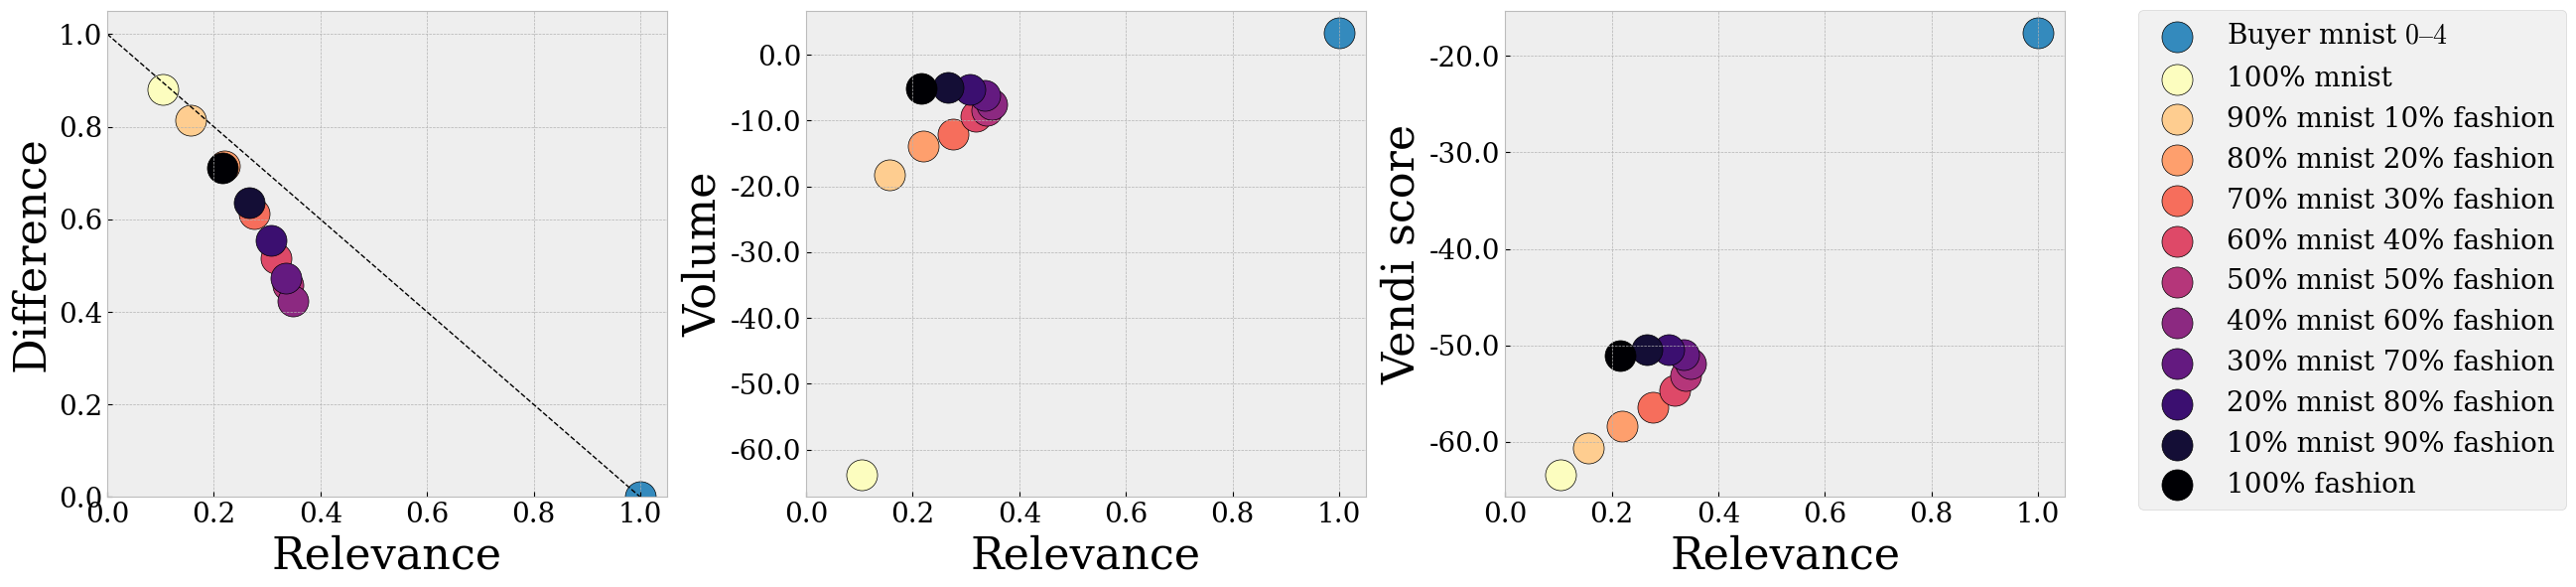

In [69]:
magma = [
    [matplotlib.colormaps["magma"].colors[int(k)]] for k in np.linspace(255, 0, 11)
]


s = 500
fig, ax = plt.subplots(figsize=(21, 6), ncols=3)

ax[0].scatter(
    buyer_values["relevance"],
    buyer_values["diversity"],
    c="C0",
    edgecolor="k",
    s=s,
    label=r"Buyer mnist $0–4$",
)
ax[0].scatter(
    seller_1_values["relevance"],
    seller_1_values["diversity"],
    c=magma[0],
    edgecolor="k",
    s=s,
    label=r"100% mnist",
)
ax[0].scatter(
    mix_1_values["relevance"],
    mix_1_values["diversity"],
    c=magma[1],
    edgecolor="k",
    s=s,
    label=r"90% mnist 10% fashion",
)
ax[0].scatter(
    mix_2_values["relevance"],
    mix_2_values["diversity"],
    c=magma[2],
    edgecolor="k",
    s=s,
    label=r"80% mnist 20% fashion",
)
ax[0].scatter(
    mix_3_values["relevance"],
    mix_3_values["diversity"],
    c=magma[3],
    edgecolor="k",
    s=s,
    label=r"70% mnist 30% fashion",
)
ax[0].scatter(
    mix_4_values["relevance"],
    mix_4_values["diversity"],
    c=magma[4],
    edgecolor="k",
    s=s,
    label=r"60% mnist 40% fashion",
)
ax[0].scatter(
    mix_5_values["relevance"],
    mix_5_values["diversity"],
    c=magma[5],
    edgecolor="k",
    s=s,
    label=r"50% mnist 50% fashion",
)
ax[0].scatter(
    mix_6_values["relevance"],
    mix_6_values["diversity"],
    c=magma[6],
    edgecolor="k",
    s=s,
    label=r"40% mnist 60% fashion",
)
ax[0].scatter(
    mix_7_values["relevance"],
    mix_7_values["diversity"],
    c=magma[7],
    edgecolor="k",
    s=s,
    label=r"30% mnist 70% fashion",
)
ax[0].scatter(
    mix_8_values["relevance"],
    mix_8_values["diversity"],
    c=magma[8],
    edgecolor="k",
    s=s,
    label=r"20% mnist 80% fashion",
)
ax[0].scatter(
    mix_9_values["relevance"],
    mix_9_values["diversity"],
    c=magma[9],
    edgecolor="k",
    s=s,
    label=r"10% mnist 90% fashion",
)
ax[0].scatter(
    fashion_values["relevance"],
    fashion_values["diversity"],
    c=magma[10],
    edgecolor="k",
    s=s,
    label=r"100% fashion",
)
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f"{x:.1f}" for x in ax[0].get_xticks()], fontsize=fontsize - 8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize - 8)
ax[0].plot(
    np.arange(0, 1.1, 0.1),
    1 - np.arange(0, 1.1, 0.1),
    marker="",
    markersize=4,
    markeredgewidth=1.5,
    color="black",
    linestyle="--",
    linewidth=1,
)
ax[0].set_xlabel("Relevance", fontsize=32)
ax[0].set_ylabel("Difference", fontsize=32)

ax[1].scatter(
    buyer_values["relevance"], buyer_values["volume"], c="C0", edgecolor="k", s=s
)
ax[1].scatter(
    seller_1_values["relevance"],
    seller_1_values["volume"],
    c=magma[0],
    edgecolor="k",
    s=s,
)
ax[1].scatter(
    mix_1_values["relevance"], mix_1_values["volume"], c=magma[1], edgecolor="k", s=s
)
ax[1].scatter(
    mix_2_values["relevance"], mix_2_values["volume"], c=magma[2], edgecolor="k", s=s
)
ax[1].scatter(
    mix_3_values["relevance"], mix_3_values["volume"], c=magma[3], edgecolor="k", s=s
)
ax[1].scatter(
    mix_4_values["relevance"], mix_4_values["volume"], c=magma[4], edgecolor="k", s=s
)
ax[1].scatter(
    mix_5_values["relevance"], mix_5_values["volume"], c=magma[5], edgecolor="k", s=s
)
ax[1].scatter(
    mix_6_values["relevance"], mix_6_values["volume"], c=magma[6], edgecolor="k", s=s
)
ax[1].scatter(
    mix_7_values["relevance"], mix_7_values["volume"], c=magma[7], edgecolor="k", s=s
)
ax[1].scatter(
    mix_8_values["relevance"], mix_8_values["volume"], c=magma[8], edgecolor="k", s=s
)
ax[1].scatter(
    mix_9_values["relevance"], mix_9_values["volume"], c=magma[9], edgecolor="k", s=s
)
ax[1].scatter(
    fashion_values["relevance"],
    fashion_values["volume"],
    c=magma[10],
    edgecolor="k",
    s=s,
)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
ax[1].set_xlabel("Relevance", fontsize=32)
ax[1].set_ylabel("Volume", fontsize=32)


ax[2].scatter(
    buyer_values["relevance"], buyer_values["vendi"], c="C0", edgecolor="k", s=s
)
ax[2].scatter(
    seller_1_values["relevance"],
    seller_1_values["vendi"],
    c=magma[0],
    edgecolor="k",
    s=s,
)
ax[2].scatter(
    mix_1_values["relevance"], mix_1_values["vendi"], c=magma[1], edgecolor="k", s=s
)
ax[2].scatter(
    mix_2_values["relevance"], mix_2_values["vendi"], c=magma[2], edgecolor="k", s=s
)
ax[2].scatter(
    mix_3_values["relevance"], mix_3_values["vendi"], c=magma[3], edgecolor="k", s=s
)
ax[2].scatter(
    mix_4_values["relevance"], mix_4_values["vendi"], c=magma[4], edgecolor="k", s=s
)
ax[2].scatter(
    mix_5_values["relevance"], mix_5_values["vendi"], c=magma[5], edgecolor="k", s=s
)
ax[2].scatter(
    mix_6_values["relevance"], mix_6_values["vendi"], c=magma[6], edgecolor="k", s=s
)
ax[2].scatter(
    mix_7_values["relevance"], mix_7_values["vendi"], c=magma[7], edgecolor="k", s=s
)
ax[2].scatter(
    mix_8_values["relevance"], mix_8_values["vendi"], c=magma[8], edgecolor="k", s=s
)
ax[2].scatter(
    mix_9_values["relevance"], mix_9_values["vendi"], c=magma[9], edgecolor="k", s=s
)
ax[2].scatter(
    fashion_values["relevance"],
    fashion_values["vendi"],
    c=magma[10],
    edgecolor="k",
    s=s,
)
ax[2].set_xlim(0, 1.05)
ax[2].set_xticklabels([f"{x:.1f}" for x in ax[1].get_xticks()], fontsize=fontsize - 8)
ax[2].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize - 8)
ax[2].set_xlabel("Relevance", fontsize=32)
ax[2].set_ylabel("Vendi score", fontsize=32)

fig.legend(prop={"size": 20}, bbox_to_anchor=(1.24, 1.00))
fig.tight_layout()
# plt.savefig(figures / f'mnist-compare-diversity-clip-mixed-n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()